<a href="https://colab.research.google.com/github/Akshat-Jaiswal/G2P/blob/master/Grapheme_to_Phoneme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grapheme to Phoneme Convertor using Transformer

**Problem Statement** : Given an orthographic representation of a word in a language generate it phonemic transcription.


**Intuition** :
The core idea behind this experiment is to apply ideas from neural machine translation to a similar seq2seq prediction task. An input word can be considered as sequence of sub tokens (single or group of characters) which need to be translated into another sequence, namely its phonemic transcript. Phonetic Alphabets are nothing but word in another langauge which makes this problem very similar to machine translation.


**Data Description** : In this implementation we'll be using CMUDict, a publicly available English Pronunciation Dictionary. For more details: http://www.speech.cs.cmu.edu/cgi-bin/cmudict.


**References** :

* The method used in this implementation is described in 
```
Yolchuyeva, Sevinj, Géza Németh, and Bálint Gyires-Tóth. "Transformer based Grapheme-to-Phoneme Conversion." arXiv preprint arXiv:2004.06338 (2020).
```
* Tensorflow Transformer tutorials:
https://www.tensorflow.org/tutorials/text/transformer

In [0]:
## base imports 
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
print(tf.__version__)

2.2.0-rc4


### Download data from CMU sphinx

In [3]:
!wget --no-check-certificate http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/sphinxdict/cmudict_SPHINX_40 -O /tmp/word2pron.tsv
!wget --no-check-certificate http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/sphinxdict/SphinxPhones_40 -O /tmp/labels.txt

--2020-05-10 16:44:54--  http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/sphinxdict/cmudict_SPHINX_40
Resolving svn.code.sf.net (svn.code.sf.net)... 216.105.38.17
Connecting to svn.code.sf.net (svn.code.sf.net)|216.105.38.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3364453 (3.2M) [text/plain]
Saving to: ‘/tmp/word2pron.tsv’

/tmp/word2pron.tsv  100%[===================>]   3.21M  3.22MB/s    in 1.0s    

2020-05-10 16:44:55 (3.22 MB/s) - ‘/tmp/word2pron.tsv’ saved [3364453/3364453]

--2020-05-10 16:44:57--  http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/sphinxdict/SphinxPhones_40
Resolving svn.code.sf.net (svn.code.sf.net)... 216.105.38.17
Connecting to svn.code.sf.net (svn.code.sf.net)|216.105.38.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105 [text/plain]
Saving to: ‘/tmp/labels.txt’

/tmp/labels.txt     100%[===================>]     105  --.-KB/s    in 0s      

2020-05-10 16:44:57 (16.7 MB/s) - ‘/tmp/labe

## Data Preperation

### Read and split data in train, valid and test sets

In [0]:
import re
features = []
labels = []
with open("/tmp/word2pron.tsv", "r") as f:
  for line in f:
    X,Y = line.split("\t")
    ## TODO : think of some better strategy for handling those
    ## initial symbols with multiple pronunciations
    features.append(re.sub("\(.*\)","", X.strip())) ## abc(2) -> abc
    labels.append(Y.strip())
label_names = []
with open("/tmp/labels.txt") as f:
  label_names = [line.strip() for line in f]

In [5]:
pron_len = list(len(f.split(' ')) for f in labels)
print(f"Total Number of Words : {len(features)}")
print(f"Max length of words : {max(len(f) for f in features)}")
print(f"Max tokens in pronunciation : {np.max(pron_len)}")
print(f"Min tokens in pronunciation : {np.min(pron_len)}")
print(f"Average tokens in pronunciation : {np.mean(pron_len)}")
print(f"Number of Distinct Phonemes : {len(label_names)}")


Total Number of Words : 133031
Max length of words : 33
Max tokens in pronunciation : 32
Min tokens in pronunciation : 1
Average tokens in pronunciation : 6.380550398027528
Number of Distinct Phonemes : 40


In [0]:
from sklearn.model_selection import train_test_split
## TODO make it generic
def split_data(features, labels, split_sizes = [0.80, 0.05, 0.15]):
  assert len(features) == len(labels)
  assert len(split_sizes) == 3
  train_X, test_X, train_Y, test_Y  = train_test_split(features, labels,test_size = np.sum(split_sizes[1:]))
  valid_X, test_X, valid_Y, test_Y = train_test_split(test_X, test_Y, test_size = np.sum(split_sizes[2:])/np.sum(split_sizes[1:]))
  return (train_X, train_Y), (valid_X, valid_Y), (test_X, test_Y)


In [7]:
(train_X, train_Y), (valid_X, valid_Y), (test_X, test_Y) = split_data(features,labels)
print(f"Train Data : {len(train_X)}, {len(train_Y)}")
print(f"Validation Data : {len(valid_X)}, {len(valid_Y)}")
print(f"Test Data : {len(test_X)}, {len(test_Y)}")

Train Data : 106424, 106424
Validation Data : 6651, 6651
Test Data : 19956, 19956


### Data Exploration

Text(0, 0.5, 'phoneme')

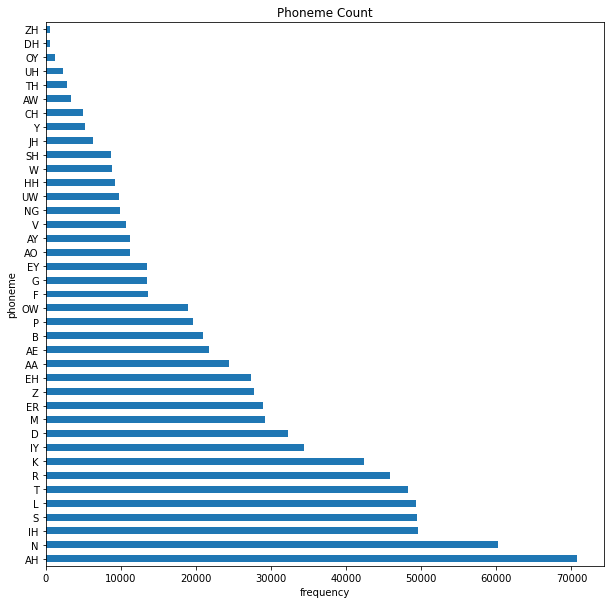

In [8]:
prons = [pron.split(" ") for pron in labels]
phons = pd.Series([phon for pron in prons for phon in pron])
ax = phons.value_counts().plot(kind="barh", figsize=(10,10), title = "Phoneme Count")
ax.set_xlabel("frequency")
ax.set_ylabel("phoneme")

Text(0, 0.5, 'Phon Count')

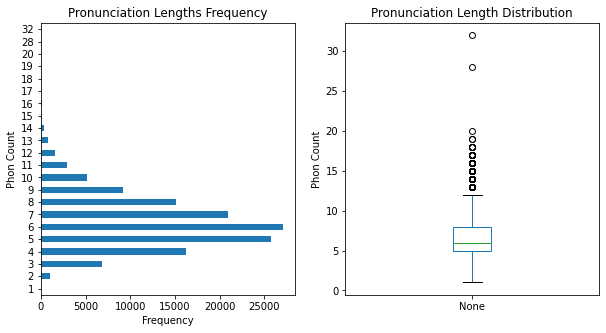

In [9]:
pron_lens = pd.Series([len(pron) for pron in prons])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
pron_lens.value_counts().sort_index().plot(kind = "barh", title = "Pronunciation Lengths Frequency", ax = ax1)
pron_lens.plot(kind = "box", title = "Pronunciation Length Distribution", ax = ax2)
ax1.set_ylabel("Phon Count")
ax1.set_xlabel("Frequency")
ax2.set_ylabel("Phon Count")

Text(0, 0.5, 'length')

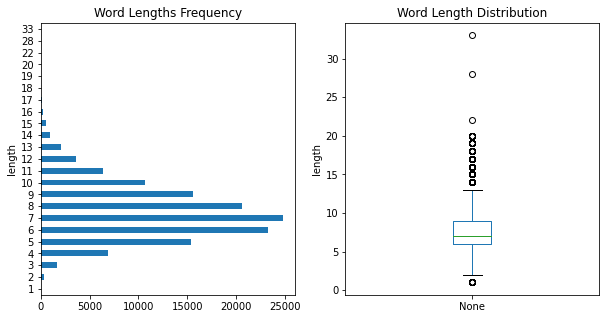

In [10]:
word_lens = pd.Series([len(word) for word in features])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word_lens.value_counts().sort_index().plot(kind = "barh", title = "Word Lengths Frequency", ax = ax1)
word_lens.plot(kind = "box", title = "Word Length Distribution", ax = ax2)
ax1.set_ylabel("length")
ax2.set_ylabel("length")

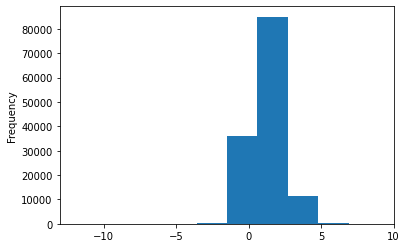

In [11]:
## Is it a simple character -> phoneme mapping ?
diff = word_lens - pron_lens
diff.plot(kind = "hist")

### Convert to tensorflow datasets

In [0]:
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_X, valid_Y))
test_data = tf.data.Dataset.from_tensor_slices((test_X, test_Y))

In [13]:
## print shapes of data
print(train_data)
for feature, label in train_data.take(1):
  print(feature)
  print(label)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>
tf.Tensor(b"GOZO'S", shape=(), dtype=string)
tf.Tensor(b'G OW Z OW Z', shape=(), dtype=string)


### Build Tokenizers for Words and Pronunciations

In [14]:
## self note : label_names were already in upper case so no conversion was required
pron_tokenizer = tfds.features.text.TokenTextEncoder(label_names)
print(f"Vocab Size : {pron_tokenizer.vocab_size}")
## sample encode/decode example
encoded = pron_tokenizer.encode("B EH D S AY D")
print(f"encoded : {encoded}")
print(f"decoded : {pron_tokenizer.decode(encoded)}")

Vocab Size : 42
encoded : [7, 11, 9, 29, 6, 9]
decoded : B EH D S AY D


In [15]:
## self note : all the words were already upper cased 
word_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus([ word.numpy() for word, pron in train_data], target_vocab_size=2**13)
# sample encode/decode example
encoded = word_tokenizer.encode("BEDSIDE")
print(f"encoded : {encoded}")
print(f"decoded : {word_tokenizer.decode(encoded)}")


encoded : [274, 728]
decoded : BEDSIDE


### Process datasets using tokenizers

In [0]:
MAX_LENGTH = 40
## append a start and end token along with encoded
def encode(word, pron):
  encoded_word = [word_tokenizer.vocab_size] + word_tokenizer.encode(word.numpy()) + [word_tokenizer.vocab_size + 1]
  encoded_pron = [pron_tokenizer.vocab_size] + pron_tokenizer.encode(pron.numpy()) + [pron_tokenizer.vocab_size + 1]
  word_len = len(encoded_word)
  pron_len = len(encoded_pron)
  ## TODO: use an inbuilt padding function from tensorflow
  return ( encoded_word + [0]*(MAX_LENGTH - word_len),
           encoded_pron + [0]*(MAX_LENGTH - pron_len))

## wrapped function for use with tf.datasets map function
def tf_encode(word, pron):
  result_word, result_pron = tf.py_function(encode, [word, pron], [tf.int64, tf.int64])
  result_word.set_shape([None])
  result_pron.set_shape([None])
  return result_word, result_pron

In [0]:
BUFFER_SIZE = 1024
BATCH_SIZE = 128
train_dataset = (train_data.map(tf_encode)
                          .cache()
                          .shuffle(BUFFER_SIZE)
                          .batch(BATCH_SIZE)
                          .prefetch(tf.data.experimental.AUTOTUNE))

valid_dataset = (valid_data.map(tf_encode)
                          .shuffle(BUFFER_SIZE)
                          .padded_batch(BATCH_SIZE))

test_dataset = (test_data.map(tf_encode)
                          .shuffle(BUFFER_SIZE)
                          .batch(BATCH_SIZE))


In [18]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)
word_batch, pron_batch = next(iter(valid_dataset))
print(word_batch)
print(pron_batch)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>
<PaddedBatchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>
<BatchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>
tf.Tensor(
[[7921 4003 7747 ...    0    0    0]
 [7921  100 4331 ...    0    0    0]
 [7921  293  209 ...    0    0    0]
 ...
 [7921  743 7922 ...    0    0    0]
 [7921 7008 4996 ...    0    0    0]
 [7921 4383  318 ...    0    0    0]], shape=(128, 40), dtype=int64)
tf.Tensor(
[[42 16  2 ...  0  0  0]
 [42 28 26 ...  0  0  0]
 [42 29 11 ...  0  0  0]
 ...
 [42  9 18 ...  0  0  0]
 [42 27 28 ...  0  0  0]
 [42 14 11 ...  0  0  0]], shape=(128, 40), dtype=int64)


## Training

### Helpers

In [0]:
## Positional Encoding helpers
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
## Masking Helpers
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [0]:
## Attention Helpers
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

### Model Layers

In [0]:
## MultiHead Attention layer
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

### Model Definition

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [0]:
## Model Hyper parameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 4

input_vocab_size = word_tokenizer.vocab_size + 2
target_vocab_size = pron_tokenizer.vocab_size + 2
dropout_rate = 0.1

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [0]:
### Masked Loss and Accuracy Functions as Input could be padded
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss(real, pred):
  '''
  Masked Sparse Categorical Cross Entropy for 0 padded input
  '''
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy(real, pred):
  '''
  Masked Sparse Categorical Accuracy for 0 padded labels
  '''
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  acc_ = tf.math.equal(tf.cast(real, tf.int64), tf.math.argmax(pred, axis=-1))
  acc_ = tf.cast(acc_, dtype=tf.int64)
  mask = tf.cast(mask, dtype=acc_.dtype)
  acc_ *= mask
  return tf.reduce_sum(acc_)/tf.reduce_sum(mask)

## Metrics
loss_metric = tf.keras.metrics.Mean("loss")
val_loss_metric = tf.keras.metrics.Mean("val_loss")
accuracy_metric = tf.keras.metrics.Mean("accuracy")
val_accuracy_metric = tf.keras.metrics.Mean("val_accuracy")

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Actual Training

In [0]:
EPOCHS = 20

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
eval_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),                       
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    padded_loss = loss(tar_real, predictions)

  gradients = tape.gradient(padded_loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  loss_metric(padded_loss)
  accuracy_metric(accuracy(tar_real, predictions))

@tf.function(input_signature=eval_step_signature)
def eval_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)  
  predictions, _ = transformer(inp, tar_inp, 
                                False,  # prediction 
                                enc_padding_mask, 
                                combined_mask, 
                                dec_padding_mask)
  padded_loss = loss(tar_real, predictions)  
  val_loss_metric(padded_loss)
  val_accuracy_metric(accuracy(tar_real, predictions))


In [38]:
import time

history = dict()
for metric in [loss_metric, val_loss_metric, accuracy_metric, val_accuracy_metric]:
  history[metric.name] = []

for epoch in range(EPOCHS):
  start = time.time()
  
  loss_metric.reset_states()
  accuracy_metric.reset_states()
  val_loss_metric.reset_states() 
  val_accuracy_metric.reset_states()

  # Training Phase
  # inp -> word, tar -> pronunciation
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, loss_metric.result(), accuracy_metric.result()))

  # Evaluation Phase
  for inp, tar in valid_dataset:
    eval_step(inp, tar)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
  for metric in [loss_metric, val_loss_metric, accuracy_metric, val_accuracy_metric]:
    history[metric.name].append(metric.result())

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                loss_metric.result(), 
                                                accuracy_metric.result()))

  print ('Epoch {} Val_Loss {:.4f} Val_Accuracy {:.4f}'.format(epoch + 1, 
                                                val_loss_metric.result(), 
                                                val_accuracy_metric.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3534 Accuracy 0.0308
Epoch 1 Batch 50 Loss 3.9672 Accuracy 0.0640
Epoch 1 Batch 100 Loss 3.6920 Accuracy 0.0921
Epoch 1 Batch 150 Loss 3.5583 Accuracy 0.1085
Epoch 1 Batch 200 Loss 3.4590 Accuracy 0.1229
Epoch 1 Batch 250 Loss 3.3828 Accuracy 0.1348
Epoch 1 Batch 300 Loss 3.3099 Accuracy 0.1465
Epoch 1 Batch 350 Loss 3.2362 Accuracy 0.1577
Epoch 1 Batch 400 Loss 3.1714 Accuracy 0.1674
Epoch 1 Batch 450 Loss 3.1134 Accuracy 0.1765
Epoch 1 Batch 500 Loss 3.0614 Accuracy 0.1850
Epoch 1 Batch 550 Loss 3.0143 Accuracy 0.1930
Epoch 1 Batch 600 Loss 2.9708 Accuracy 0.2008
Epoch 1 Batch 650 Loss 2.9310 Accuracy 0.2081
Epoch 1 Batch 700 Loss 2.8936 Accuracy 0.2153
Epoch 1 Batch 750 Loss 2.8584 Accuracy 0.2222
Epoch 1 Batch 800 Loss 2.8259 Accuracy 0.2289
Epoch 1 Loss 2.8062 Accuracy 0.2328
Epoch 1 Val_Loss 2.1636 Val_Accuracy 0.3739
Time taken for 1 epoch: 163.1176688671112 secs

Epoch 2 Batch 0 Loss 2.3037 Accuracy 0.3532
Epoch 2 Batch 50 Loss 2.2566 Accuracy 0.3484
Epoc

In [39]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  1807232   
_________________________________________________________________
decoder (Decoder)            multiple                  1063936   
_________________________________________________________________
dense_64 (Dense)             multiple                  5676      
Total params: 2,876,844
Trainable params: 2,876,844
Non-trainable params: 0
_________________________________________________________________


### Visualize Loss and Accuracy 

<Figure size 432x288 with 0 Axes>

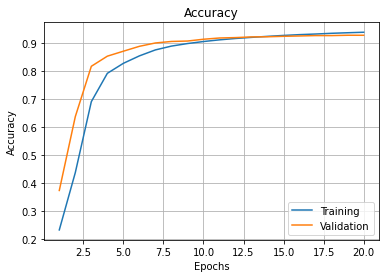

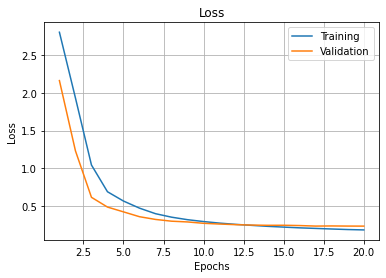

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

epochs=range(1, len(train_acc)+1) # Get number of epochs

#------------------------------------------------
# Plot Training Vs Validation Accuracy
#------------------------------------------------
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["Training", "Validation"])

plt.figure()

#------------------------------------------------
# Plot Training Vs Validation Loss
#------------------------------------------------
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(["Training", "Validation"])

plt.figure()

## Prediction

### Inference Helpers

In [0]:
def evaluate(inp_word):
  start_token = [word_tokenizer.vocab_size]
  end_token = [word_tokenizer.vocab_size + 1]
  
  # inp sentence is word, hence adding the start and end token
  inp_sentence = start_token + word_tokenizer.encode(inp_word.upper()) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is pronunciation, the first word to the transformer should be the
  # pron start token
  decoder_input = [pron_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == pron_tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = word_tokenizer.encode(sentence.upper())
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[word_tokenizer.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([pron_tokenizer.decode([i]) for i in result 
                        if i < pron_tokenizer.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(word, plot=''):
  '''
  Return phonemic transcript for a given word.
  Note: Works best for a single word only. Use multiple calls for each separate word
  in a sentence.

  Parameters
  ----------
  word : string (input word)
  plot : string (layer to plot)

  Returns
  -------
  string
  '''
  result, attention_weights = evaluate(word)
  
  predicted_pron = pron_tokenizer.decode([i for i in result 
                                            if i < pron_tokenizer.vocab_size])    
  if plot:
    plot_attention_weights(attention_weights, word, result, plot)
  return predicted_pron

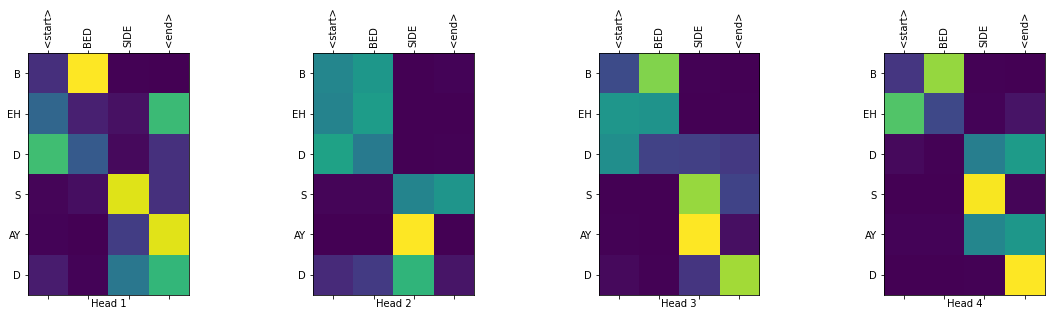

Our translation: B EH D S AY D
Real translation: B EH D S AY D


In [44]:
predicted = translate("bedside", plot = "decoder_layer4_block2")
print(f"Our translation: {predicted}") 
print("Real translation: B EH D S AY D")

### Compute WER or PER

In [0]:
def wed(r, h):
    """
    Source - https://holianh.github.io/portfolio/Cach-tinh-WER/
    Word Edit Distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.

    Parameters
    ----------
    r : list
    h : list

    Returns
    -------
    int

    Examples
    --------
    >>> wed("who is there".split(), "is there".split())
    1
    >>> wed("who is there".split(), "".split())
    3
    >>> wed("".split(), "who is there".split())
    3
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

def wer(r, h):
  return float(wed(r,h))/len(r)


In [46]:
gt_pred = []
start_time = time.time()
## Just take a sample for now
for i, (word, pron) in enumerate(zip(test_X[:1000], test_Y[:1000])):
  prediction = translate(word)
  if i % 100 == 0:
    print(f" Iteration {i} completed -> {time.time()-start_time} secs")
    start_time = time.time()
  gt_pred.append((pron, prediction))

 Iteration 0 completed -> 1.7390172481536865 secs
 Iteration 100 completed -> 106.22399735450745 secs
 Iteration 200 completed -> 104.23004341125488 secs
 Iteration 300 completed -> 105.36749458312988 secs
 Iteration 400 completed -> 105.75328040122986 secs
 Iteration 500 completed -> 106.00467658042908 secs
 Iteration 600 completed -> 106.71405053138733 secs
 Iteration 700 completed -> 112.56272745132446 secs
 Iteration 800 completed -> 105.76243805885315 secs
 Iteration 900 completed -> 101.8128764629364 secs


In [47]:
print(f"Phoneme Error Rate: {np.mean([ wer(r.split(" "), p.split(" ")) for r, p in gt_pred ])}")

0.09543929126429125
